# SigPy for MRI Tutorial Part 1: Gridding Reconstruction

Welcome!

In this notebook, we will go through basic features of SigPy using the gridding reconstruction as an example usage. Gridding is a core operation in non-Cartesian MRI, but still can be a computational bottleneck in many applications. We will show how SigPy can easily change parameters and computing devices to speed things up.

Before moving on to the tutorial, we want to point out our [documentation](https://sigpy.readthedocs.io) if you want to find out more information about each function.


## Setup
If you haven't installed SigPy already, please follow the [installation instructions](https://sigpy.readthedocs.io/en/latest/index.html#installation), and come back to this tutorial after.

SigPy is designed to use along with NumPy. In particular, SigPy operates on NumPy arrays directly, and relies on NumPy to provide basic data manipulation functions. Almost aways, we will import NumPy along with SigPy.

We will also import the [sigpy.plot](https://sigpy.readthedocs.io/en/latest/plot.html) sub-module for plotting. The module provides convenient plotting functions for multi-dimensional arrays. Only hot-keys are needed for controlling the plots. We will use them to show images, but will not focus on them in this tutorial.

Finally, the `%matplotlib notebook` magic allows us to get interactive plots in jupyter notebooks.

In [15]:
%matplotlib inline
import numpy as np
import sigpy as sp
import sigpy.plot as pl

We will use a non-Cartesian dataset created by Prof. Martin Uecker for the [ISMRM reproducible challenge](https://blog.ismrm.org/2019/04/02/ismrm-reproducible-research-study-group-2019-reproduce-a-seminal-paper-initiative/). The dataset contains k-space measurements of a brain scan acquired with a projection reconstruction trajectory. We have re-saved the dataset in NumPy data format. Let us load the dataset and look at the array shapes.

In [11]:
ksp = np.load('data/projection_ksp.npy')
coord = np.load('data/projection_coord.npy')

print('k-space array shape: {} (Ncoils x Nreps x Nreadout)'.format(ksp.shape))
print('coordinate array shape: {} (Nreps x Nreadout x Ncoords)'.format(coord.shape))

k-space array shape: (12, 96, 512) (Ncoils x Nreps x Nreadout)
coordinate array shape: (96, 512, 2) (Nreps x Nreadout x Ncoords)


First, a few words about array shapes. Because NumPy by default stores arrays by row-major, the array shapes are flipped compared to what you would expect in Matlab or Fortran, which uses column-major. The k-space array has its shape arranged as number of coil channels, number of repetitions, and number of readout points. The coordinate array has its shape arranged as number of repetitions, number of readout points and number of dimensions. In this case, you can see this is a 2D dataset, because the last dimension of `coord` is 2.

## Gridding Reconstruction

In gridding reconstruction, we approximate the inverse Fourier transform by a element-wise multiplication operation to compensate for density, followed by the non-uniform fast Fourier transform (NUFFT) adjoint operation.

First, we will need the density compensation factor (`dcf`). For the projection reconstruction trajectory, it is proportional to the radius of the k-space coordinates. 

Let us compute the density compensation factor and visualize it with the function [ScatterPlot](https://sigpy.readthedocs.io/en/latest/generated/sigpy.plot.ScatterPlot.html#sigpy.plot.ScatterPlot):

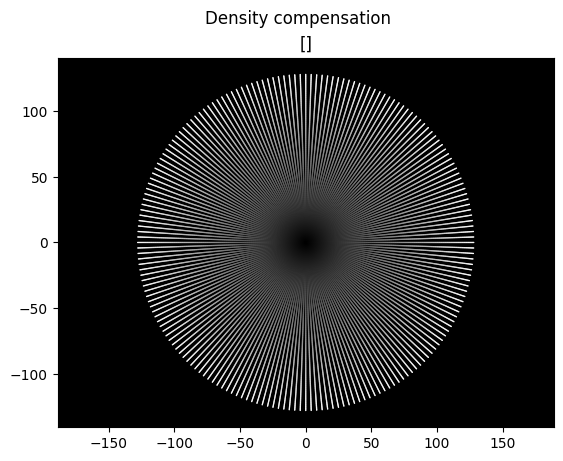

In [30]:
dcf = (coord[..., 0]**2 + coord[..., 1]**2)**0.5
sigplot = pl.ScatterPlot(coord, dcf, title='Density compensation')

To perform a gridding reconstruction, we simply call [nufft_adjoint](https://sigpy.readthedocs.io/en/latest/generated/sigpy.nufft_adjoint.html#sigpy.nufft_adjoint) on the density compensated k-space `ksp * dcf`. The function will loop through the coil dimension. This is inferred by the difference between the coordinate array and k-space array dimensions. Applying the function gives us the gridded multi-channel images:

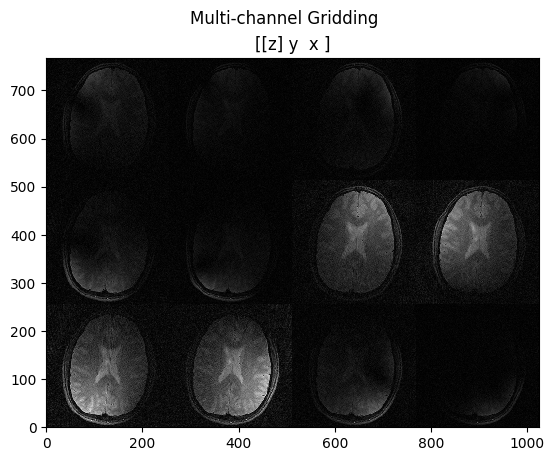

In [31]:
img_grid = sp.nufft_adjoint(ksp * dcf, coord)
pl.ImagePlot(img_grid, z=0, title='Multi-channel Gridding')

We will combine the coil images by performing root-sum-of-squares along the coil dimension. This can be easily done using NumPy functions:

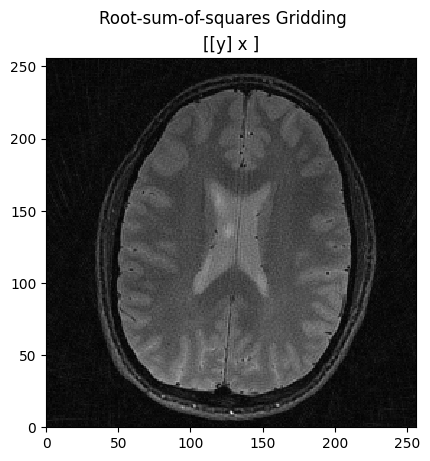

In [32]:
img_rss = np.sum(np.abs(img_grid)**2, axis=0)**0.5
pl.ImagePlot(img_rss, title='Root-sum-of-squares Gridding')

The gridding reconstruction isn't too slow, but perhaps we might want it to be faster when we have a stack of images. One way we can make the reconstruction faster is tuning the oversampling ratio `oversamp` and kernel widths `width` of [nufft_adjoint](https://sigpy.readthedocs.io/en/latest/generated/sigpy.nufft_adjoint.html#sigpy.nufft_adjoint).

We will prepend the magic command `% time` to the nufft_adjoint call to time it. Feel free to change the nufft parameters and see how they affect the run-time and artifacts!

CPU times: user 35.1 ms, sys: 15.7 ms, total: 50.8 ms
Wall time: 49.1 ms


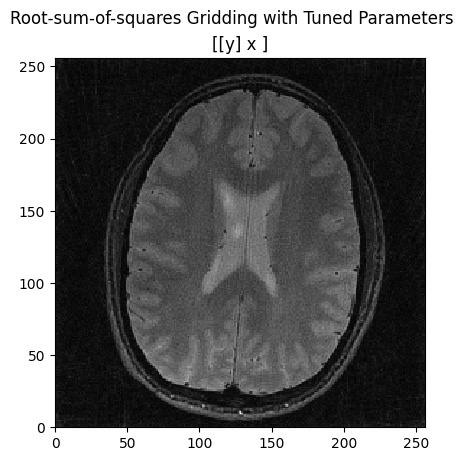

In [33]:
%time img_grid_tune = sp.nufft_adjoint(ksp * dcf, coord, oversamp=1, width=2)

img_rss_tune = np.sum(np.abs(img_grid_tune)**2, axis=0)**0.5
pl.ImagePlot(img_rss_tune, title='Root-sum-of-squares Gridding with Tuned Parameters')

As you can see, smaller oversampling ratio and kernel width cause artifacts near the image boundaries. But because the image is occupying a slightly smaller field-of-view, these artifacts may be fine if we only care about the brain.

## Gridding Reconstruction on GPU

A main feature of SigPy is that most functions can run on both CPU and GPU with the same interface. To run `nufft_adjoint` on GPU, all we have to do is to move the arrays to a GPU device, and wrap the function with a SigPy GPU device context. If you have some experience with Tensorflow or Pytorch, this is similar to how they specify computing devices as well.

The following shows a conceptual illustration of running operations on GPU 1 when you have two GPUs. Each device is numbered, with -1 reserved for CPU.
![device](https://sigpy.readthedocs.io/en/latest/_images/device.png)

In order to run the following code, you will need to have a GPU, and install the package [cupy](https://cupy.chainer.org). We will use GPU 0. Try adding `%time` to time the speedup.

In [7]:
device = sp.Device(0)

ksp_gpu = sp.to_device(ksp, device=device)
coord_gpu = sp.to_device(coord, device=device)
dcf_gpu = sp.to_device(dcf, device=device)

with device:
    img_grid_gpu = sp.nufft_adjoint(ksp_gpu * dcf_gpu, coord_gpu)

pl.ImagePlot(img_grid_gpu, z=0, title='GPU Multi-channel Gridding')

ValueError: cupy not installed, but set device 0.

Similar to using NumPy for the root-sum-of-squares operation, we use CuPy for GPU operations. CuPy is essentialy NumPy for GPU, with the same syntax. We will import the library, and perform root-sum-of-squares.

<IPython.core.display.Javascript object>


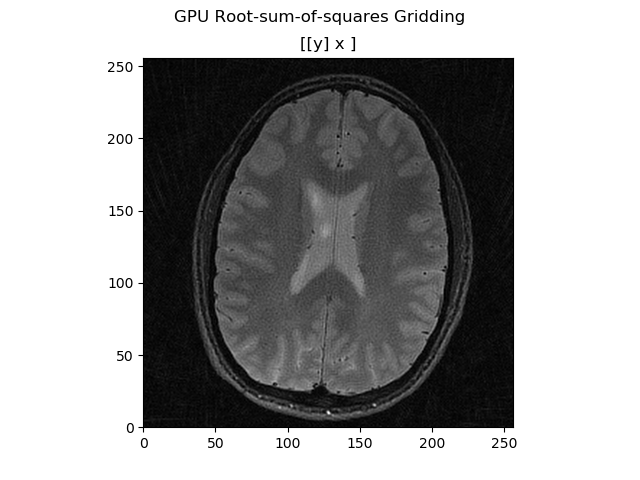

In [ ]:
import cupy as cp
with device:
    img_rss_gpu = cp.sum(cp.abs(img_grid_gpu)**2, axis=0)**0.5

pl.ImagePlot(img_rss_gpu, title='GPU Root-sum-of-squares Gridding')

And that's it! This is how you can use SigPy for gridding reconstruction on CPU and GPU. There are also many other [signal processing functions](https://sigpy.readthedocs.io/en/latest/core.html), such as  `fft`, `array_to_blocks` and `convolve`, that you may find useful for processing MRI datasets. They are all run on CPU and GPU.

For MRI iterative reconstructions, SigPy provides many pre-built reconstruction [App](https://sigpy.readthedocs.io/en/latest/generated/sigpy.app.App.html#sigpy.app.App)s so that you don't have to start from scratch. Please check out [part 2](02-parallel-imaging-compressed-sensing-reconstruction.ipynb) of the tutorial to find out more.